In [10]:
'''This script loads pre-trained word embeddings (GloVe embeddings)
into a frozen Keras Embedding layer, and uses it to
train a text classification model on the 20 Newsgroup dataset
(classification of newsgroup messages into 20 different categories).

GloVe embedding data can be found at:
http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html
'''

from __future__ import print_function

import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K



In [11]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [2]:

BASE_DIR = '/Volumes/My Passport for Mac/data'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [3]:

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))


Processing text dataset
Found 19997 texts.


In [4]:

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]


Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


In [5]:

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


Preparing embedding matrix.


In [25]:

print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', f1_m, precision_m, recall_m])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          validation_data=(x_val, y_val))

Training model.
Train on 15998 samples, validate on 3999 samples
Epoch 1/15
15998/15998 [==============================] - 39s 2ms/step - loss: 2.4789 - acc: 0.1931 - f1_m: 0.0579 - precision_m: 0.3516 - recall_m: 0.0326 - val_loss: 2.0228 - val_acc: 0.3003 - val_f1_m: 0.1145 - val_precision_m: 0.7768 - val_recall_m: 0.0623
Epoch 2/15
15998/15998 [==============================] - 40s 2ms/step - loss: 1.5932 - acc: 0.4531 - f1_m: 0.3541 - precision_m: 0.7005 - recall_m: 0.2413 - val_loss: 1.3911 - val_acc: 0.5329 - val_f1_m: 0.4018 - val_precision_m: 0.8638 - val_recall_m: 0.2633
Epoch 3/15
15998/15998 [==============================] - 40s 2ms/step - loss: 1.2443 - acc: 0.5744 - f1_m: 0.5293 - precision_m: 0.7577 - recall_m: 0.4084 - val_loss: 1.3067 - val_acc: 0.5824 - val_f1_m: 0.4898 - val_precision_m: 0.8606 - val_recall_m: 0.3439
Epoch 4/15
15998/15998 [==============================] - 39s 2ms/step - loss: 1.0421 - acc: 0.6476 - f1_m: 0.6218 - precision_m: 0.7941 - recall_m: 0.5

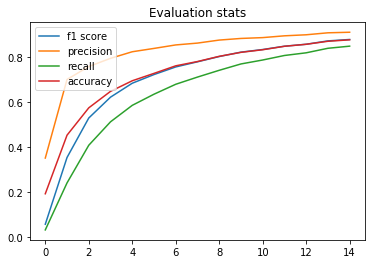

In [26]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")
pyplot.plot(history.history["precision_m"], label="precision")
pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [ ]:

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")



In [ ]:

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))